In [1]:
import re
import numpy as np

from matplotlib import cm

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

import numpy as np

In [2]:
# The BBFWA is mostly from the original impelentation: https://github.com/cilatpku/firework-algorithm/
class BBFWA(object):

    def  __init__(self):
        # Parameters

        # params of method
        self.sp_size = None       # total spark size
        self.init_amp = None      # initial dynamic amplitude
        
        # params of problem
        self.evaluator = None
        self.dim = None
        self.upper_bound = None
        self.lower_bound = None

        self.max_iter = None
        self.max_eval = None
        
        self.params = None # for the function 


        # States

        # private states
        self._num_iter = None
        self._num_eval = None
        self._dyn_amp = None

        # public states
        self.best_idv = None    # best individual found
        self.best_fit = None    # best fitness found
        self.trace = None       # trace of best individual in each generation

        # for inspection
        self.time = None
        
        # params for animation
        self.fireworks = None
        self.fits = None
        self.graph = None
        self.init = True
        

    def load_prob(self, 
                  # params for prob
                  evaluator = None,
                  params = [],
                  dim = 2,
                  upper_bound = 3,
                  lower_bound = -3,
                  max_iter = 1000,
                  max_eval = 1000,
                  # params for method
                  sp_size = 2,
                  init_amp = 5,
                  ):

        # load params
        self.evaluator = evaluator
        self.dim = dim
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        #self.params = params

        self.max_iter = max_iter
        self.max_eval = max_eval

        self.sp_size = sp_size
        self.init_amp = init_amp
        
        # init states
        self._num_iter = 0
        self._num_eval = 0
        self._dyn_amp = init_amp
        self.best_idv = None
        self.best_fit = None
        self.trace = []

        self.time = 0
        self.graph = None
        self.init = True
        self.terminate = False
        
        global fireworks
        global fits
        fireworks, fits = self._init_fireworks()

    def run(self, frameidx): 
        if self._terminate():
            return 

        global fireworks
        global fits
        fireworks, fits, animation_obj = self.iter(fireworks, fits)
         
        return animation_obj

    def iter(self, fireworks, fits):
        e_sparks, e_fits, animation_obj = self._explode(fireworks, fits)
         
        n_fireworks, n_fits = self._select(fireworks, fits, e_sparks, e_fits)    

        if np.all(n_fits < fits):
            self._dyn_amp *= 1.2
        else:
            self._dyn_amp *= 0.9

        self._num_iter += 1
        self._num_eval += len(e_sparks)
            
        self.best_idv = n_fireworks
        self.best_fit = n_fits
        self.trace.append([n_fireworks, n_fits, self._dyn_amp])

        fireworks = n_fireworks
        fits = n_fits
        
        return fireworks, fits, animation_obj

    def _init_fireworks(self):
    
        fireworks = np.random.uniform(self.lower_bound, 
                                      self.upper_bound, 
                                      [2, self.dim])
        
        fireworks = fireworks.tolist()
        fits = self.evaluator(fireworks)

        return fireworks, fits

    def _terminate(self):
        if self._num_iter >= self.max_iter:
            return True
        if self._num_eval >= self.max_eval:
            return True
        return False

    def _explode(self, fireworks, fits):
        
        bias = np.random.uniform(-self._dyn_amp, self._dyn_amp, [self.sp_size, self.dim])
        rand_samples = np.random.uniform(self.lower_bound, self.upper_bound, [self.sp_size, self.dim])
        e_sparks = fireworks + bias
        in_bound = (e_sparks > self.lower_bound) * (e_sparks < self.upper_bound)
        e_sparks = in_bound * e_sparks + (1 - in_bound) * rand_samples
        e_sparks = e_sparks.tolist()
        e_fits = self.evaluator(e_sparks)
        global ax
        
        if self.init:
            self.graph = ax.scatter(e_sparks[0], e_sparks[1], e_fits) 
            self.init = False
        else:
            self.graph._offsets3d = (e_sparks[0], e_sparks[1], e_fits)
        
        return e_sparks, e_fits, ax    

    def _select(self, fireworks, fits, e_sparks, e_fits):
        idvs = fireworks + e_sparks
        fits = np.append(fits, e_fits).reshape(2, self.dim)
        idx = np.argmin(fits)
        idx = int(idx/np.shape(idvs)[1])
 
        if idx == 0:
            idvs = fireworks
        else:
            idvs = e_sparks

        return idvs, fits[idx]


In [3]:
def obj_function(params):
    x = np.asarray(params[0])
    y = np.asarray(params[1])
    result = 3*(1-x)**2*np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2 - y**2) 
    
    return result
    

In [4]:
Z = []
X = Y = nums = np.arange(-4, 4, 0.1)
X, Y = np.meshgrid(X, Y)
params = [X,Y]
Z = obj_function(params)

In [5]:
algo = BBFWA()
algo.load_prob(evaluator=obj_function, dim=30, max_eval=10000,)

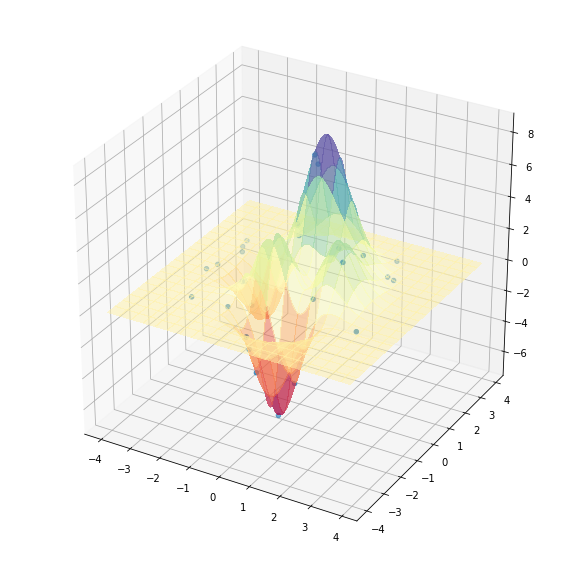

In [6]:
# Figure and axes instance
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.Spectral,
                       linewidth=0, antialiased=False, rstride=4, cstride=4, alpha=0.50)

# Plot wireframe
#surf = ax.plot_wireframe(X, Y, Z, rstride=4, cstride=4)

# Custom rotation
#ax.view_init(70, 30)

# Save the animation
ani = animation.FuncAnimation(fig, algo.run, frames=200)
writer = PillowWriter(fps = 5)
ani.save("FWA_animation.gif", writer=writer)